# Assemble rotation period data for the two Kepler clusters and crossmatch them with Gaia.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from tqdm import tqdm

In [10]:
def convert_hours_to_degrees(df, ra_name, dec_name):
    """
    Returns the dataframe, df, with additional columns "ra" and "dec".
    """
    RA, DE = [], [] #[np.zeros(len(douglas)) for i in range(2)]
    for i in range(len(df)):     
        coords = "{0} {1}".format(df[ra_name].values[i], df[dec_name].values[i])
        c = SkyCoord(coords, unit=(u.hourangle, u.deg))
        RA.append(c.ra.degree)
        DE.append(c.dec.degree)
    df["ra"] = RA
    df["dec"] = DE
    return df

In [13]:
N19 = pd.read_csv("../data/NGC6819.csv")
N19 = convert_hours_to_degrees(N19, "RAJ2000", "DEJ2000")
N19.head()

,KIC,B-V,prot,prot_err,RAJ2000,DEJ2000,ra,dec
0,5111207,0.41,5.42,1.05,19 40 09.01,40 12 16.7,295.037542,40.204639
1,5023899,0.42,4.81,0.44,19 40 55.90,40 10 04.7,295.232917,40.167972
2,5023760,0.43,4.78,0.10,19 40 49.33,40 09 07.0,295.205542,40.151944
3,5024227,0.43,5.06,0.39,19 41 09.49,40 11 41.6,295.289542,40.194889
4,5024122,0.45,6.36,1.04,19 41 05.50,40 08 28.4,295.272917,40.141222


In [14]:
N11 = pd.read_csv("../data/NGC6811.csv", skiprows=51)
N11 = convert_hours_to_degrees(N11, "RAJ2000", "DEJ2000")
N11.head()

,KIC,RAJ2000,DEJ2000,gmag,rmag,Per,e_Per,o_Per,Mm,Simbad,ra,dec
0,9715923,19 36 39.33,+46 27 01.8,13.62,13.36,0.92,0.01,5,CSM,Simbad,294.163875,46.450500
1,9594100,19 36 55.98,+46 15 18.5,13.22,12.95,0.96,0.01,6,CSM,Simbad,294.233250,46.255139
2,9716563,19 37 38.57,+46 29 12.7,13.92,13.57,1.29,0.21,4,SM,Simbad,294.410708,46.486861
3,9716817,19 37 59.91,+46 24 44.7,14.55,14.14,1.36,0.01,4,SM,Simbad,294.499625,46.412417
4,9654924,19 36 41.17,+46 23 09.5,13.94,13.65,1.60,0.22,4,CSM,Simbad,294.171542,46.385972


Load Bedell Kepler crossmatch.

In [50]:
with fits.open("../data/kepler_dr2_4arcsec_updated.fits") as data:
    bedell = pd.DataFrame(data[1].data)

Create mini bedell versions of the regions around the cluster data.

In [108]:
# NGC 6819
m = bedell.ra.values < 295.8
m &= 295 < bedell.ra.values
m &= bedell.dec.values < 40.3
m &= 40. < bedell.dec.values

# Create a mini Gaia catalogue so you don't run into memory issues.
b19 = pd.DataFrame(dict({"source_id": bedell.source_id.values[m]}))
for key in bedell.keys():
    b19["{}".format(key)] = bedell["{}".format(key)].values[m]    
print(np.shape(b19))

# NGC 6811
m = bedell.ra.values < 295
m &= 293 < bedell.ra.values
m &= bedell.dec.values < 46.9
m &= 45.9 < bedell.dec.values

# Create a mini Gaia catalogue so you don't run into memory issues.
b11 = pd.DataFrame(dict({"source_id": bedell.source_id.values[m]}))
for key in bedell.keys():
    b11["{}".format(key)] = bedell["{}".format(key)].values[m]    
print(np.shape(b11))

(995, 101)
(6797, 101)


# NGC 6819

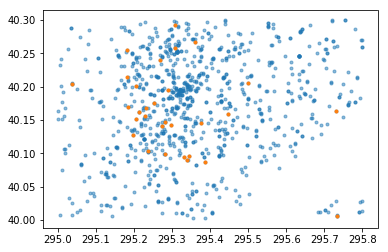

In [53]:
plt.plot(b19.ra.values, b19.dec.values, ".", zorder=0, alpha=.5)
plt.plot(N19.ra, N19.dec, ".", zorder=1)

In [54]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    """
    ind1 is a list of indices the same length as ra1 and dec1 that identifies matching stars in ra1 and dec1.
    ind2 is a list of indices the same length as ra2 and dec2 that identifies matching stars in ra2 and dec2.
    """
    id1, id2 = np.ones((len(ra1)))*np.nan, np.ones((len(ra2)))*np.nan
    ind1, ind2 = [], []
    for i in tqdm(range(len(ra1))):
        e2 = np.sqrt((ra2.values - ra1.values[i])**2 + (dec2.values - dec1.values[i])**2)
        min_distance = min(e2)
        if min_distance < dist_arcsecs/3600.:
            m = e2 == min_distance
            if sum(m) > 1:  # If there is a star (a) within 5 arcsecs of this target star (i)
                m = np.arange(len(ra2))[m[0]]  # create an index mask, selecting the position of star a
            if not np.arange(len(ra2))[m] in np.array(ind2):  # If this star has not already been identified
                ind1.append(i)  # add i to the list of inds1
                ind2.append(np.arange(len(ra2))[m])  # Add a to the list of inds2
                id1[i] = i
                id2[m] = i
    
    m1, m2 = np.zeros(len(ra1), dtype="bool"), np.zeros(len(ra2), dtype="bool")
    for i in ind1:
        m1[i] = True
    for i in ind2:
        m2[i] = True
    return m1, m2, id1, id2

In [97]:
inds1_19, inds2_19, id1_19 , id2_19 = find_min_dist(b19.ra, b19.dec, N19.ra, N19.dec, dist_arcsecs=2)

100%|██████████| 995/995 [00:00<00:00, 35372.92it/s]


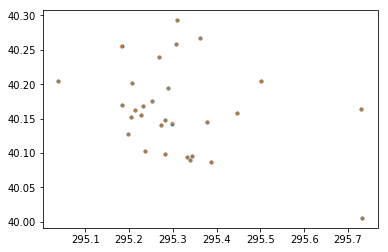

In [98]:
plt.plot(b19.ra.values[inds1_19], b19.dec.values[inds1_19], ".", zorder=0)
plt.plot(N19.ra.values[inds2_19], N19.dec.values[inds2_19], ".", zorder=1, alpha=.5)

In [99]:
b19["id"] = id1_19
N19["id"] = id2_19
m1 = np.isfinite(b19.id.values)
m2 = np.isfinite(N19.id.values)

df19 = pd.merge(b19[m1], N19[m2], on="id", suffixes=["_gaia", "_kepler"])
print(np.shape(b19), np.shape(N19), np.shape(df19))

df19.to_csv("../data/NGC6819_gaia.csv")

(995, 102) (30, 9) (29, 110)


Check the pairings.

77.0 77.0
[ 77.  95.  99. 100. 119. 165. 210. 219. 224. 227. 253. 256. 260. 276.
 290. 310. 315. 327. 460. 508. 602. 621. 647. 665. 709. 757. 759. 820.
 905.]


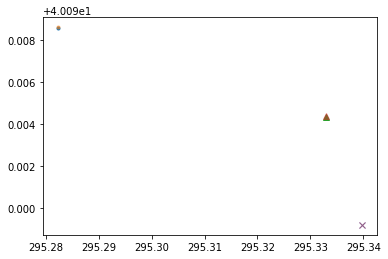

In [102]:
print(min(b19.id.values[m1]), min(N19.id.values[m2]))
print(b19.id.values[m1])
plt.plot(b19.ra.values[b19.id.values==77], b19.dec.values[b19.id.values==77], ".", zorder=0);
plt.plot(N19.ra.values[N19.id.values==77], N19.dec.values[N19.id.values==77], ".", zorder=1, alpha=.5);
plt.plot(b19.ra.values[b19.id.values==95], b19.dec.values[b19.id.values==95], "^", zorder=0);
plt.plot(N19.ra.values[N19.id.values==95], N19.dec.values[N19.id.values==95], "^", zorder=1, alpha=.5);
plt.plot(b19.ra.values[b19.id.values==99], b19.dec.values[b19.id.values==99], "x", zorder=0);
plt.plot(N19.ra.values[N19.id.values==99], N19.dec.values[N19.id.values==99], "x", zorder=1, alpha=.5);

Looks ok to me.

<Container object of 3 artists>

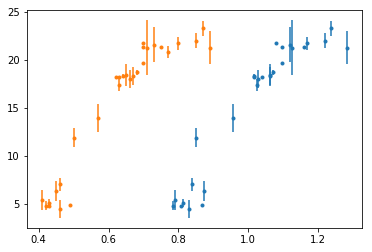

In [101]:
plt.errorbar(df19.phot_bp_mean_mag - df19.phot_rp_mean_mag, df19.prot, yerr=df19.prot_err, fmt=".")
plt.errorbar(df19["B-V"], df19.prot, yerr=df19.prot_err, fmt=".")

# NGC 6811

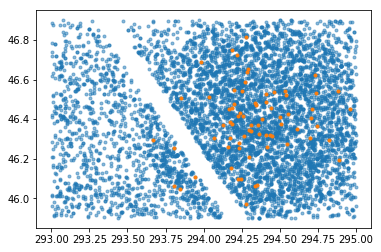

In [109]:
plt.plot(b11.ra.values, b11.dec.values, ".", zorder=0, alpha=.5)
plt.plot(N11.ra, N11.dec, ".", zorder=1)

In [110]:
inds1_11, inds2_11, id1_11 , id2_11 = find_min_dist(b11.ra, b11.dec, N11.ra, N11.dec, dist_arcsecs=2)

100%|██████████| 6797/6797 [00:00<00:00, 31226.89it/s]


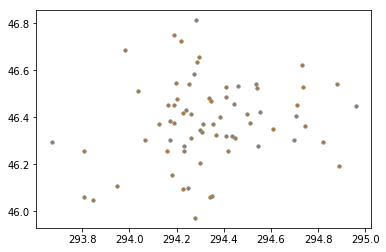

In [114]:
plt.plot(b11.ra.values[inds1_11], b11.dec.values[inds1_11], ".", zorder=0)
plt.plot(N11.ra.values[inds2_11], N11.dec.values[inds2_11], ".", zorder=1, alpha=.5)

In [115]:
b11["id"] = id1_11
N11["id"] = id2_11
m1 = np.isfinite(b11.id.values)
m2 = np.isfinite(N11.id.values)

df11 = pd.merge(b11[m1], N11[m2], on="id", suffixes=["_gaia", "_kepler"])
print(np.shape(b11), np.shape(N11), np.shape(df11))

(6797, 102) (71, 13) (70, 114)


Check the indices

[ 242.  627.  651.  755.  769.  827.  832. 1314. 1390. 1795. 1942. 2003.
 2136. 2189. 2190. 2228. 2308. 2380. 2545. 2876. 2900. 2917. 2919. 2924.
 2993. 3013. 3025. 3027. 3088. 3101. 3135. 3151. 3168. 3227. 3287. 3317.
 3336. 3795. 3820. 3828. 3853. 3865. 3891. 3941. 3947. 3965. 3990. 4002.
 4038. 4065. 4142. 4144. 4265. 4513. 4631. 4689. 4707. 4781. 4802. 4855.
 4867. 4976. 5057. 5308. 5475. 5479. 5730. 6106. 6123. 6606.]


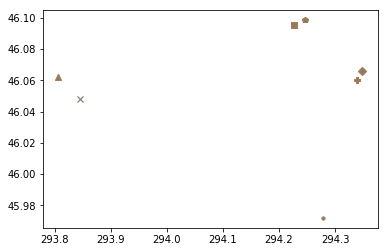

In [127]:
print(b11.id.values[m1])
markers = [".", "^", "x", "s", "p", "P", "D"]
for i in range(len(markers)):
    _b = b11.id.values==b11.id.values[m1][i]
    _n = N11.id.values==b11.id.values[m1][i]
    plt.plot(b11.ra.values[_b], b11.dec.values[_b], "{}".format(markers[i]), color="tab:blue", zorder=0);
    plt.plot(N11.ra.values[_n], N11.dec.values[_n], "{}".format(markers[i]), color="tab:orange", zorder=1, alpha=.5);

<Container object of 3 artists>

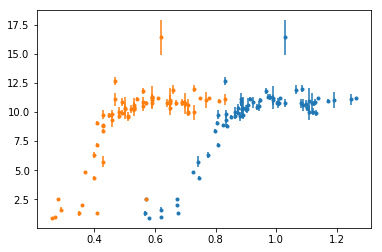

In [131]:
plt.errorbar(df11.phot_bp_mean_mag - df11.phot_rp_mean_mag, df11.Per, yerr=df11.e_Per, fmt=".")
plt.errorbar(df11.gmag - df11.rmag, df11.Per, yerr=df11.e_Per, fmt=".")

In [132]:
df11.to_csv("../data/NGC6811_gaia.csv")